# Homework 2: Text Classification
## Due Date: (TBD)
## Total Points: (TBD)
- **Overview**: For this assignment, we’ll be building a text classifier. The goal of our text classifer will be to distinguish between words that are simple and words that are complex. Example simple words are `heard`, `sat`, and `town`, and example complex words are `abdicate`, `detained`, and `vintners`. Distinguishing between simple and complex words is the first step in a larger NLP task called text simplification, which aims to replace complex words with simpler synonyms. Text simplification is potentially useful for re-writing texts so that they can be more easily understood by younger readers, people learning English as a second language, or people with learning disabilities.

- **Learning goals**:
    - Understand an important class of NLP evaluation methods (precision, recall and F1), and implement them yourself.
    - Employ common experimental design practices in NLP. Split the annotated data into training/development/test sets, implement simple baselines to determine how difficult the task is, and experiment with a range of features and models.
    - Get an introduction to `sklearn`, an excellent machine learning Python package.

- **Data**: We will provide you with training and development data that has been manually labeled. We will also give you a test set without labels. You will build a classifier to predict the labels on our test set. You can upload your classifier’s predictions to Gradescope. We will score its predictions and maintain a leaderboard showing whose classifier has the best performance.

---
- **Delieverables:** This assignment has several deliverables:
  - Code (this notebook) *(Automatic Graded)*
    - rename to `homework2.ipynb` and `homework2.py`.
  - Write Up (in a separate **writeup.pdf**) *(Manually Graded)*
    - Answers to all questions labeled as `Answer #.#` in a file named `writeup.pdf`
  - Leaderboard: Section 4 *(Automatic Graded on GradeScope)*
    - Your best model’s output for the test set using only the provided training and development data (`test_labels.txt`)
    - (Optional) your best model’s output for the test set, using any data that you want. (`test_labels.txt`)

- **Grading**: We will use the auto-grading system called `PennGrader`. To complete the homework assignment, you should implement anything marked with `#TODO` or `##YOUR CODE HERE` and run the cell with `#PennGrader` note.

## Recommended Readings
- [Naive Bayes Classification and Sentiment](https://web.stanford.edu/~jurafsky/slp3/4.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft).
- [Logistic Regression](https://web.stanford.edu/~jurafsky/slp3/5.pdf) Dan Jurafsky and James H. Martin. Speech and Language Processing (3rd edition draft) .
- [Problems in Current Text Simplification Research: New Data Can Help](http://www.cis.upenn.edu/~ccb/publications/new-data-for-text-simplification.pdf) Wei Xu, Chris Callison-Burch, and Courtney Napoles. TACL 2015.
- [Comparison of Techniques to Automatically Identify Complex Words](http://aclweb.org/anthology/P/P13/P13-3015.pdf) Matthew Shardlow. ACL 2013.
- [SemEval 2016 Task 11: Complex Word Identification](https://www.researchgate.net/profile/Gustavo_Paetzold/publication/305334627_SemEval_2016_Task_11_Complex_Word_Identification/links/57bab70a08ae14f440bd9722/SemEval-2016-Task-11-Complex-Word-Identification.pdf) Gustavo Paetzold and Lucia Specia. ACL 2016.

## Setup 1: PennGrader Setup

In [2]:
## DO NOT CHANGE ANYTHING, JUST RUN
%%capture
!pip install penngrader-client dill

In [3]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [4]:
!cat notebook-config.yaml


grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'


In [5]:
from penngrader.grader import *

## TODO - Start
STUDENT_ID = 62502470 # YOUR PENN-ID GOES HERE AS AN INTEGER#
## TODO - End

SECRET = STUDENT_ID
grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 62502470

Make sure this correct or we will not be able to store your grade


In [6]:
def reload_grader():
    grader = PennGrader('notebook-config.yaml', 'CIS5300_OL_23Su_HW2', STUDENT_ID, SECRET)
    return grader

In [7]:
# check if the PennGrader is set up correctly
# do not chance this cell, see if you get 4/4!
name_str = 'Rui Jiang'
grader.grade(test_case_id = 'name_test', answer = name_str)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Setup 2: Dataset / Packages
- **Run the following cells without changing anything!**
- [Loading dataset from huggingface](https://huggingface.co/docs/datasets/v1.8.0/loading_datasets.html#from-local-files)

In [8]:
from collections import defaultdict
import gzip

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import numpy as np
from tqdm import tqdm
from dill.source import getsource

In [9]:
#%%capture
# data
!gdown 16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ # https://drive.google.com/file/d/16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ/view?usp=sharing
!gdown 17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk # https://drive.google.com/file/d/17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk/view?usp=sharing
!gdown 1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK # https://drive.google.com/file/d/1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK/view?usp=sharing
!gdown 1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z # https://drive.google.com/file/d/1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z/view?usp=sharing
!curl -L -o ngram_counts.txt.gz http://www.cis.upenn.edu/~cis5300/18sp/data/ngram_counts.txt.gz

Downloading...
From: https://drive.google.com/uc?id=16KoidumvFEoI9hliqgrPiWhvhFHkqMEJ
To: /content/complex_words_test_unlabeled.txt
100% 181k/181k [00:00<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xaJNRt3DY2zhEgBE2zj0JEuMqf8CCdk
To: /content/complex_words_training.txt
100% 798k/798k [00:00<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JX-G-olW84eckkGW-1OC-5XeVJ-Yx3RK
To: /content/complex_words_development.txt
100% 198k/198k [00:00<00:00, 122MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ppyM-7kFyabNG8zOudsTuhWl-2j-zy5Z
To: /content/complex_words_test_mini.txt
100% 396/396 [00:00<00:00, 1.54MB/s]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   272  100   272    0     0   3134      0 --:--:-- --:--:-- --:--:--  3162
100 42.4M  100 42.4M    0     0  43.5M      0 --:--:-- --:--:-- --:--:-- 52.0M


In [10]:
!gdown 1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s

Downloading...
From (original): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s
From (redirected): https://drive.google.com/uc?id=1rkYaFae_qJk1AlHORDLH3aPH47f9DA8s&confirm=t&uuid=487d9fa7-da8d-452e-a12c-0ff3a506743e
To: /content/ngram_counts.txt.gz
100% 44.5M/44.5M [00:00<00:00, 119MB/s]


In [11]:
train_file = "complex_words_training.txt"
dev_file = "complex_words_development.txt"
test_file = "complex_words_test_unlabeled.txt"
mini_test_file = 'complex_words_test_mini.txt'

In [12]:
########## DO NOT CHANGE ##########
## Loads in the words and labels of one of the datasets
def load_labeled_file(data_file):
    words = []
    labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

def load_unlabeled_file(data_file):
    words = []
    # labels = []
    with open(data_file, 'rt', encoding="utf8") as f:
        words = [line.strip() for line in f.readlines() if len(line.strip()) > 0]
    return words

def load_test_file(data_file):
    words = []
    with open(data_file, 'rt', encoding="utf8") as f:
        next(f) # skip first line (header)
        words = [line.strip().split('\t')[0] for line in f.readlines() if len(line.strip()) > 0]
    return words

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file = 'ngram_counts.txt.gz'):
    counts = defaultdict(int)
    with gzip.open(ngram_counts_file, 'rt') as f:
        for line in f:
            token, count = line.strip().split('\t')
            if token[0].islower():
                counts[token] = int(count)
    return counts
ngram_counts = load_ngram_counts()

### About the data
- `train_data`, `dev_data`: these are words with labels, provided for you to train and evaluate your models.
- `mini_test_words`: this is a subset (50) of the unseen test dataset, we will provide test the **basic functionality** of your models based on the performance on this mini testset (PennGrader tests). **This would only be a basic sanity check of your implementation. The final grade would be based on the PennGrader Grades and manual grading on your implementation**
- `test_words`: this is the full, unlabelled test set. You are expected to submit the prediction of these words at the end of the assignment.

In [13]:
########## DO NOT CHANGE ##########
train_data = load_labeled_file(train_file)
dev_data = load_labeled_file(dev_file)
mini_test_words = load_unlabeled_file(mini_test_file)
test_words = load_test_file(test_file)

# you can take a look at this mini-dev data by uncommenting this line
dev_words, dev_labels = dev_data
dev_words[:5] # some examples of this dev dataset

['hammer', 'renewable', 'showings', 'academy', 'continues']

In [ ]:
mini_test_words[:5]

['threads', 'reinforce', 'letters', 'pioneered', 'closer']

# Section 1. Implement the Evaluation Metrics
- You might find this [Wikipedia Page](https://en.wikipedia.org/wiki/Precision_and_recall) useful.
- **Problem 1.1** Predicion, Recall, F1 Score

In [14]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_true, y_pred):
    ## YOUR CODE HERE...
    n = len(y_pred)
    num_true_positive = 0
    num_false_positive = 0
    for i in range(n):
      if y_pred[i]:
        if y_true[i]:
          num_true_positive += 1
        else:
          num_false_positive += 1
    if num_true_positive + num_false_positive == 0:
        return 0.0  # Avoid division by zero
    return num_true_positive/ (num_true_positive + num_false_positive)

## Calculates the recall of the predicted labels
def get_recall(y_true, y_pred):
    ## YOUR CODE HERE...
    n = len(y_pred)
    num_true_positive = 0
    num_false_negative = 0
    for i in range(n):
      if y_pred[i]:
        if y_true[i]:
          num_true_positive += 1
      else: # y_pred[i] == False
        if y_true[i]: # y_true[i] == True
          num_false_negative += 1
    if num_true_positive + num_false_negative == 0:
        return 0.0  # Avoid division by zero
    recall = num_true_positive/ (num_true_positive + num_false_negative)
    return recall

## Calculates the f-score of the predicted labels
def get_fscore(y_true, y_pred):
    ## YOUR CODE HERE...
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)

    if (precision + recall) == 0.0:
      return 0.0
    fscore = (2 * precision * recall) / (precision + recall)
    return fscore

In [15]:
# PennGrader - DO NOT CHANGE
# grader.grade(test_case_id = 'test_q11_eval_funcs', answer = (get_precision, get_recall, get_fscore))
grader.grade(test_case_id = 'test_q11_eval_funcs', answer = [getsource(get_precision), getsource(get_recall), getsource(get_fscore)])

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 2. Baselines

## 2.1 Implement a majority class baseline
You should start by implementing simple baselines as classifiers. Your first baseline is a **majority class baseline** which is one of the most simple classifier. You should complete the function `all_complex(words)`, which takes in a list of words, and returns out the predictions.


- **Problem 2.1:** Implement `all_complex()` that always predicts the majority class of the data (i.e. predicting every word as complex)

In [16]:
## Labels every word complex
def all_complex(words):
    ## YOUR CODE HERE...
    y_pred = []
    for word in words:
      y_pred.append(True)
    return y_pred

In [17]:
dev_words, dev_labels = dev_data

- **Answer 2.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [18]:
dev_words, dev_labels = dev_data
y_pred = all_complex(dev_words)
precision = get_precision(dev_labels, y_pred)
recall = get_recall(dev_labels, y_pred)
fscore = get_fscore(dev_labels, y_pred)
fscore
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("fscore is {}".format(fscore))

precision is 0.418
recall is 1.0
fscore is 0.5895627644569816


In [21]:
# training data
training_words, training_labels = train_data
y_pred = all_complex(training_words)
tprecision = get_precision(training_labels, y_pred)
trecall = get_recall(training_labels, y_pred)
tfscore = get_fscore(training_labels, y_pred)
print("tprecision is {}".format(tprecision))
print("trecall is {}".format(trecall))
print("tfscore is {}".format(tfscore))

tprecision is 0.43275
trecall is 1.0
tfscore is 0.604083057058105


In [22]:
# PennGrader - DO NOT CHANGE
all_complex_pred = all_complex(mini_test_words)
grader.grade(test_case_id = 'test_baseline_q21', answer = all_complex_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2 Word length baseline
For our next baseline, we will use a slightly complex baseline, the length of each word to predict its complexity.

For the word length baseline, you should try setting various thresholds for word length to classify them as simple or otherwise. For example, you might set a threshold of 9, meaning that any words with less than 9 characters will be labeled simple, and any words with 9 characters or more will be labeled complex. Once you find the best threshold using the training data, use this same threshold for the development data as well.

You will be filling in the function `word_length_threshold(train_data, dev_data)`. This function takes in both the training and development datasets, finds the best threshold on word length and returns out the predictions on development data for your best threshold.

Usually, Precision and Recall are inversely related and while building binary-classification systems we try to find a good balance between them (by maximizing f-score, for example). It is often useful to plot the Precision-Recall curve for various settings of the classifier to gauge its performance and compare it to other classifiers. For example, for this baseline, a Precision-Recall curve can be plotted by plotting the Precision (on the y-axis) and Recall (on the X-axis) for different values of word-length threshold.

- **Problem 2.2:** Implement `word_length_threshold()` that finds the best word length threshold and makes predictions on the development (or testing) data.

In [23]:
### 2.2: Word length thresholding
## Makes feature matrix for word_length_threshold

global_word_length_threshold = 7

def length_threshold_feature(words, threshold):
    # return predictions based on the threshold
    if len(words) < threshold:
      return False # simple words
    return True # complex words

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(train_data, dev_words):
    twords, tlabels = train_data

    ## YOUR CODE HERE
    dev_pred = []
    for word in dev_words:
      dev_pred.append(length_threshold_feature(word, global_word_length_threshold))
    return dev_pred

- **Answer 2.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**
    - Range of thresholds tested using the training data **[writeup.pdf]**
    - Best threshold **[writeup.pdf]**
    - Precision-recall Curve for training data **[writeup.pdf]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [24]:
dev_words, dev_labels = dev_data
y_pred = word_length_threshold(train_data, dev_words)
dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
print("dprecision is {}".format(dprecision))
print("drecall is {}".format(drecall))
print("dfscore is {}".format(dfscore))

dprecision is 0.6053511705685619
drecall is 0.8660287081339713
dfscore is 0.7125984251968505


In [25]:
def word_length_threshold_with_length(train_data, dev_words, length_threshold):
    twords, tlabels = train_data

    ## YOUR CODE HERE
    dev_pred = []
    for word in dev_words:
      dev_pred.append(length_threshold_feature(word, length_threshold))
    return dev_pred

precision_list = []
recall_list = []
fscore_list = []
max_fscore = 0
max_threshold = 0
for threshold in range (1, 13):
  dev_words, dev_labels = dev_data
  y_pred = word_length_threshold_with_length(train_data, dev_words, threshold)
  dprecision = get_precision(dev_labels, y_pred)
  drecall = get_recall(dev_labels, y_pred)
  dfscore = get_fscore(dev_labels, y_pred)
  precision_list.append(dprecision)
  recall_list.append(drecall)
  fscore_list.append(dfscore)
  if dfscore > max_fscore:
    max_fscore = dfscore
    max_threshold = threshold

print("precision_list {}".format(precision_list))
print("recall_list {}".format(recall_list ))
print("fscore_list {}".format(fscore_list))
print("max_fscore {}, max_threshold {}".format(max_fscore, max_threshold))

precision_list [0.418, 0.418, 0.418, 0.4256619144602851, 0.4649321266968326, 0.5270805812417437, 0.6053511705685619, 0.6807095343680709, 0.7346278317152104, 0.7593582887700535, 0.7899159663865546, 0.7647058823529411]
recall_list [1.0, 1.0, 1.0, 1.0, 0.9832535885167464, 0.9545454545454546, 0.8660287081339713, 0.7344497607655502, 0.5430622009569378, 0.3397129186602871, 0.22488038277511962, 0.12440191387559808]
fscore_list [0.5895627644569816, 0.5895627644569816, 0.5895627644569816, 0.5971428571428571, 0.6313364055299538, 0.6791489361702128, 0.7125984251968505, 0.7065592635212887, 0.624484181568088, 0.4694214876033058, 0.3500931098696462, 0.2139917695473251]
max_fscore 0.7125984251968505, max_threshold 7


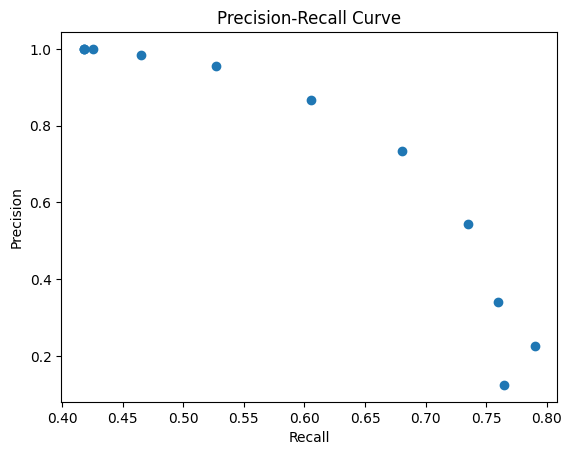

In [26]:
import matplotlib.pyplot as plt
# precision = [0.35555555555555557, 0.35555555555555557, 0.35555555555555557, 0.35555555555555557, 0.35555555555555557, 0.35555555555555557, 0.35555555555555557, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173, 0.34782608695652173]
# recall = [0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249, 0.03827751196172249]
# labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
# for i in range(12):
#     # plt.text(precision[i], recall[i], labels[i], fontsize=8)
#     plt.annotate(labels[i], (precision[i], recall[i]))
plt.scatter(precision_list, recall_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [27]:
# training data
training_words, training_labels = train_data
y_pred = []
for word in training_words:
  y_pred.append(length_threshold_feature(word, 7))
tprecision = get_precision(training_labels, y_pred)
trecall = get_recall(training_labels, y_pred)
tfscore = get_fscore(training_labels, y_pred)
print("tprecision is {}".format(tprecision))
print("trecall is {}".format(trecall))
print("tfscore is {}".format(tfscore))

tprecision is 0.6007401315789473
trecall is 0.8440207972270364
tfscore is 0.7018976699495555


In [28]:
# PennGrader - DO NOT CHANGE
word_length_pred = word_length_threshold(train_data, mini_test_words)
grader.grade(test_case_id = 'test_baseline_q22', answer = word_length_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.3 Word frequency baseline


Our final baseline is a classifier similar to the last one, but thresholds on word frequency instead of length. We have provided Google NGram frequencies in the text file ngram_counts.txt, along with the helper function `load_ngram_counts(ngram_counts_file)` to load them into Python as a dictionary.

You will be filling in the function `word_frequency_threshold(train_data, dev_data, ngram_counts)`, where `ngram_counts` is the dictionary of word frequencies. This function again finds the best threshold and returns predictions on the development data.

Please again report the precision, recall, and f-score on the training and development data individually, along with the range of thresholds you tried, and the best threshold to be graded. Similar to the previous baseline, plot the Precision-Recall curve for range of thresholds you tried. Compared with word length baseline, which classifier looks better on average?

**Note: Due to its size, loading the ngram counts into Python takes around 20 seconds, and finding the correct threshold may take a few minutes to run.**

- **Problem 2.3:** Implement `word_frequency_threshold()` that finds the best word frequency threshold and makes predictions on the development (or testing) data.

In [29]:
## Make feature matrix for word_frequency_threshold
def frequency_threshold_feature(words, threshold, ngram_counts):
    # return predictions based on the threshold
    ## YOUR CODE HERE
    # hint: check the content of `ngram_counts` variable
    # if words not in ngram_counts:
    #   return True
    if ngram_counts[words] > threshold:
      return False # simple words
    return True # complex words

def word_frequency_threshold(train_data, dev_words, ngram_counts):
    twords, tlabels = train_data

    ## YOUR CODE HERE

    dev_pred = []
    for word in dev_words:
      dev_pred.append(frequency_threshold_feature(word, 15100000, ngram_counts))
    return dev_pred

dev_words, dev_labels = dev_data
y_pred = word_frequency_threshold(train_data, dev_words, ngram_counts)

dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
# dfscore
print("dprecision is {}".format(dprecision))
print("drecall is {}".format(drecall))
print("dfscore is {}".format(dfscore))

dprecision is 0.5784982935153583
drecall is 0.8110047846889952
dfscore is 0.6752988047808764


In [30]:
# training data
training_words, training_labels = train_data
y_pred = []
for word in training_words:
  y_pred.append(frequency_threshold_feature(word, 15100000, ngram_counts))
tprecision = get_precision(training_labels, y_pred)
trecall = get_recall(training_labels, y_pred)
tfscore = get_fscore(training_labels, y_pred)
print("tprecision is {}".format(tprecision))
print("trecall is {}".format(trecall))
print("tfscore is {}".format(tfscore))

tprecision is 0.5816102067751869
trecall is 0.7637203928365107
tfscore is 0.6603396603396602


In [31]:
ngram_counts
max_count = 0
min_count = 1000000
for word, counts in ngram_counts.items():
  if max_count < counts:
    max_count = counts
  if min_count > counts:
    min_count = counts

print("max_count {} min_count {}".format(max_count, min_count))

max_count 47376829651 min_count 0


precision_list is [0.417910447761194, 0.6071428571428571, 0.6353591160220995, 0.6406926406926406, 0.6327272727272727, 0.636963696369637, 0.6265432098765432, 0.6283185840707964, 0.6226415094339622, 0.6186868686868687, 0.6151960784313726, 0.6157517899761337, 0.6143187066974596, 0.6139954853273137, 0.6088888888888889, 0.6082251082251082, 0.6098081023454158, 0.6096033402922756, 0.6094069529652352, 0.6105476673427992, 0.6063618290258449, 0.6058823529411764, 0.603112840466926, 0.6022944550669216, 0.5955056179775281, 0.5908256880733945, 0.5901639344262295, 0.5875, 0.5848056537102474, 0.5826086956521739, 0.5784982935153583, 0.5760135135135135, 0.5688225538971807, 0.5681444991789819, 0.5633116883116883, 0.5631067961165048, 0.5603864734299517, 0.56, 0.5569620253164557, 0.5569620253164557, 0.5566037735849056, 0.5545171339563862, 0.5526315789473685, 0.5497702909647779, 0.5487804878048781, 0.5501519756838906, 0.5496987951807228, 0.5496987951807228, 0.5477611940298508, 0.5466666666666666, 0.54491899

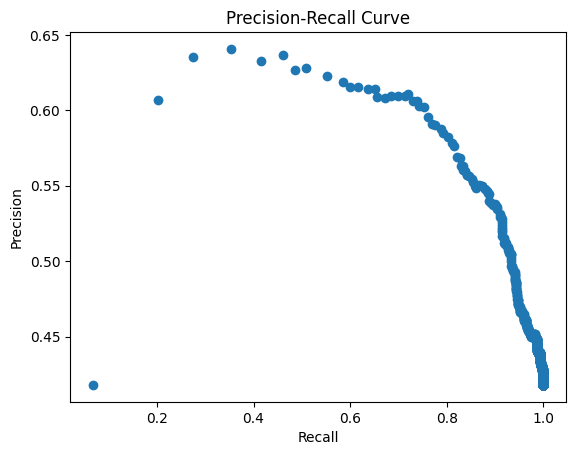

In [32]:
def word_frequency_threshold_frequency(train_data, dev_words, ngram_counts, frequency):
    twords, tlabels = train_data

    ## YOUR CODE HERE

    dev_pred = []
    for word in dev_words:
      dev_pred.append(frequency_threshold_feature(word, frequency, ngram_counts))
    return dev_pred

def run_multiple_round(train_data, dev_words, ngram_counts):
  precision_list = []
  recall_list = []
  fscore_list = []
  frequency_list = []
  max_fscore = 0
  max_threshold = 0
  for i in range(100000, 47376829651, 500000):
    dev_words, dev_labels = dev_data
    y_pred = word_frequency_threshold_frequency(train_data, dev_words, ngram_counts, i)
    dprecision = get_precision(dev_labels, y_pred)
    drecall = get_recall(dev_labels, y_pred)
    dfscore = get_fscore(dev_labels, y_pred)
    precision_list.append(dprecision)
    recall_list.append(drecall)
    fscore_list.append(dfscore)
    frequency_list.append(i)
    if dfscore > max_fscore:
      max_fscore = dfscore
      max_threshold = i

  return precision_list, recall_list, fscore_list, frequency_list, max_fscore, max_threshold

dev_words, dev_labels = dev_data
freq_precision_list, freq_recall_list, freq_fscore_list, frequency_list, max_fscore, max_threshold = run_multiple_round(train_data, dev_words, ngram_counts)
print("precision_list is {}".format(freq_precision_list))
print("recall_list is {}".format(freq_recall_list))
print("fscore_list is {}".format(freq_fscore_list))
print("max_fscore {} max_threshod {}".format(max_fscore, max_threshold))

import matplotlib.pyplot as plt
plt.scatter(freq_recall_list, freq_precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
print("max_fscore {} max_threshod {}".format(max_fscore, max_threshold))

max_fscore 0.6752988047808764 max_threshod 15100000


In [33]:
index = 0
for threshold in frequency_list:
  index += 1
  if threshold == 15100000:
    print("index is {}".format(index))

index is 31


In [34]:
freq_recall_list[30]

0.8110047846889952

In [35]:
freq_precision_list[30]

0.5784982935153583

- **Answer 2.3:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**
    - Range of thresholds tested using the training data **[writeup.pdf]**
    - Best threshold **[writeup.pdf]**
    - Precision-recall Curve for training data **[writeup.pdf]**
        - For plotting, [matplotlib](https://matplotlib.org/) is a useful python library

In [36]:
dev_words, dev_labels = dev_data
y_pred = word_frequency_threshold(train_data, dev_words, ngram_counts)

dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
# dfscore
print("dprecision is {}".format(dprecision))
print("drecall is {}".format(drecall))
print("dfscore is {}".format(dfscore))

dprecision is 0.5784982935153583
drecall is 0.8110047846889952
dfscore is 0.6752988047808764


In [37]:
# PennGrader - DO NOT CHANGE
word_freq_pred = word_frequency_threshold(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_baseline_q23', answer = word_freq_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# Section 3. Classifiers

## 3.1 Naive Bayes classification


Now, let’s move on to actual machine learning classifiers! For our first classifier, you will use the built-in [Naive Bayes model from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), to train a classifier. You should refer to the online sklearn documentation when you are building your classifier.

The first thing to note is that sklearn classifiers take in `numpy` arrays, rather than regular lists. You may use the [online numpy documentation](https://numpy.org/doc/stable/). To create a `numpy` list of length 5, you can use the following Python commands:

```
import numpy as np
X = np.array([1,2,3,4,5])
```


To train a classifier, you need two numpy arrays: `X_train`, an `m` by `n` array, where `m` is the number of words in the dataset, and `n` is the number of features for each word; and `Y`, an array of length `m` for the labels of each of the words.

**Before we start training models, we need to convert our texts/words into numpy arrays, i.e. making training/testing feature vectors.**

- **Problem 3.0**: Implementing `get_training_features()` and `get_test_features()` that convert train/test dataset to numpy arrays

In [19]:
%%capture
# run the following cell if you want to use count of syllabus as a feature
!pip install syllables
import syllables

In [39]:
# True means complex word
# False means: simple word
def syllables_threshold_feature(word, threshold):
  return syllables.estimate(word) < threshold

def syllables_threshold(train_data, dev_words):
    twords, tlabels = train_data

    ## YOUR CODE HERE

    dev_pred = []
    for word in dev_words:
      dev_pred.append(syllables_threshold_feature(word, 7))
    return dev_pred

dev_words, dev_labels = dev_data
y_pred = syllables_threshold(train_data, dev_words)

dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)

print("dprecision is {}".format(dprecision))
print("drecall is {}".format(drecall))
print("dfscore is {}".format(dfscore))

dprecision is 0.418
drecall is 1.0
dfscore is 0.5895627644569816


In [40]:


def get_training_features(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 9)
        unigram_feature = frequency_threshold_feature(word, 200, ngram_counts)
        syllables_feature = syllables_threshold_feature(word, 7)
        features.append([length_feature, unigram_feature, syllables_feature])

    X = np.asarray(features)
    ## YOUR CODE HERE
    # TODO: calculate the mean and std of the vectorized data (X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    Y = np.asarray(y_true)
    return X_scaled, Y, means, stds

def get_test_features(dev_words, ngram_counts, means, stds):

    ## YOUR CODE HERE
    # TODO: do the similar thing, except using means and stds as given (from training data)
    features = []
    for word in dev_words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 9)
        unigram_feature = frequency_threshold_feature(word, 200, ngram_counts)
        syllables_feature = syllables_threshold_feature(word, 7)
        features.append([length_feature, unigram_feature, syllables_feature])

    X = np.asarray(features)
    X_scaled = (X - means) / stds

    return X_scaled

In [41]:
# PennGrader - DO NOT CHANGE
dev_words, dev_labels = dev_data
X_train, Y_train, means, stds = get_training_features(train_data, ngram_counts)
X_dev = get_test_features(dev_words, ngram_counts, means, stds)

train_feats = (X_train, Y_train, means, stds)
test_feats = (X_dev)

grader.grade(test_case_id = 'test_q30_test_feature_shapes', answer = (train_feats, test_feats))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once we have these feature arrays, we can fit a Naive Bayes classifier using the following commands:
```
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, Y)
```
Finally, to use your model to predict the labels for a set of words, you only need one numpy array: `X_test`, an `m` by `n` array, where `m` is the number of words in the test set, and `n` is the number of features for each word. Note that the `n` used here is the same as the `n` in `X_train`. Then, we can use our classifier to predict labels using the following command:

```
Y_pred = clf.predict(X_test)
```

- **Problem 3.1**: Fill in the function `naive_bayes(train_data, dev_data, ngram_counts)`. This function will train a Naive Bayes classifier on the training data using **word length** and **word frequency** as features, and returns your model’s predictions on the training data and the development data individually.
    - **NOTE**: Before training and testing a classifier, it is generally important to normalize your features. This means that you need to find the mean and standard deviation (sd) of a feature. Then, for each row, perform the following transformation: `X_scaled = (X_original - mean)/sd`. **Be sure to always use the means and standard deviations from the training data**.
    - **Optional**: You can include more features if you want to, e.g. [the count of syllabus](https://github.com/prosegrinder/python-syllables)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [42]:
def get_naive_bayes_threshold_feature_test(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100000, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 2)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    clf.fit(X_scaled, y_true)

    train_pred = clf.predict(X_scaled)
    return y_true, train_pred


y_true, train_pred = get_naive_bayes_threshold_feature_test(train_data, ngram_counts)


In [43]:
def get_naive_bayes_threshold_feature(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100000, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # if syllables_feature is None:
        #   print(word)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    clf.fit(X_scaled, y_true)

    train_pred = clf.predict(X_scaled)
    return train_pred, clf

## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(train_data, dev_words, ngram_counts):
    # TODO
    # 1. Gets the features from the training data, and trains the model
    # 2. Train model & inference on dev_words
    ## YOUR CODE HERE
    # train_pred, dev_pred = None, None
    train_pred, clf = get_naive_bayes_threshold_feature(train_data, ngram_counts)

    features = []
    for word in dev_words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 9)
        unigram_feature = frequency_threshold_feature(word, 200, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds

    dev_pred = clf.predict(X_scaled)

    return train_pred, dev_pred

- **Answer 3.1:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [44]:
# report train/development metrics!
dev_words, dev_labels = dev_data
train_pred, dev_pred = naive_bayes(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
dev_f

0.624484181568088

In [45]:
# added by me to report train set
tmp, train_labels = train_data
train_pred, model = get_naive_bayes_threshold_feature(train_data, ngram_counts)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)

print("train_precision is {}".format(train_precision))
print("train_recall is {}".format(train_recall))
print("train_fscore is {}".format(train_fscore))


train_precision is 0.6840796019900498
train_recall is 0.635470826112074
train_fscore is 0.6588799041629231


In [46]:
# added by me
dev_words, dev_labels = dev_data
nb_train_pred, nb_dev_pred = naive_bayes(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, nb_dev_pred)
dev_recall = get_recall(dev_labels, nb_dev_pred)
dev_f = get_fscore(dev_labels, nb_dev_pred)
dev_f

print("dev_precision is {}".format(dev_precision))
print("dev_recall is {}".format(dev_recall))
print("dev_fscore is {}".format(dev_f))

dev_precision is 0.7346278317152104
dev_recall is 0.5430622009569378
dev_fscore is 0.624484181568088


In [47]:
dev_precision

0.7346278317152104

In [48]:
dev_recall

0.5430622009569378

In [49]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = naive_bayes(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_naive_bayes', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.2 Logistic Regression
Next, you will use sklearn’s built-in Logistic Regression classifier. Again, we will use word length and word frequency as your two features. You should refer to [the online sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) when you are building your classifier. To import and use this model, use the following command:

```
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
```

- **Problem 3.2**: For this problem, you will be filling in the function `logistic_regression(train_data, dev_data, ngram_counts)`. This function will train a `Logistic Regression` classifier on the training data, and returns your model’s predictions on the training data and the development data individually.


In [50]:
from sklearn.linear_model import LogisticRegression

def get_logistic_threshold_feature(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    classifier = LogisticRegression()
    classifier.fit(X_scaled, y_true)

    train_pred = classifier.predict(X_scaled)

    return train_pred, classifier

## Trains a logistic regression classifier using length and frequency features
def logistic_regression(train_data, dev_words, ngram_counts):
    ## TODO
    # train_pred, dev_pred = None, None
    train_pred, classifier = get_logistic_threshold_feature(train_data, ngram_counts)

    features = []
    for word in dev_words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds

    dev_pred = classifier.predict(X_scaled)

    return train_pred, dev_pred

In [51]:
# added by me to report train set
tmp, train_labels = train_data
train_pred, model = get_logistic_threshold_feature(train_data, ngram_counts)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)

print("train_precision is {}".format(train_precision))
print("train_recall is {}".format(train_recall))
print("train_fscore is {}".format(train_fscore))

train_precision is 0.6128888888888889
train_recall is 0.7966493356441363
train_fscore is 0.6927907560914344


- **Answer 3.2:** Please report the precision, recall, and f-score on both the training data and the development data.
    - Training **[writeup.pdf]**
    - Development **[writeup.pdf]**

In [52]:
dev_words, dev_labels = dev_data
train_pred, dev_pred = logistic_regression(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, dev_pred)
dev_recall = get_recall(dev_labels, dev_pred)
dev_f = get_fscore(dev_labels, dev_pred)
dev_f

0.712809917355372

In [53]:
dev_words, dev_labels = dev_data
lr_train_pred, lr_dev_pred = logistic_regression(train_data, dev_words, ngram_counts)
dev_precision = get_precision(dev_labels, lr_dev_pred)
dev_recall = get_recall(dev_labels, lr_dev_pred)
dev_f = get_fscore(dev_labels, lr_dev_pred)

print("dev_precision is {}".format(dev_precision))
print("dev_recall is {}".format(dev_recall))
print("dev_fscore is {}".format(dev_f))

dev_precision is 0.6272727272727273
dev_recall is 0.8253588516746412
dev_fscore is 0.712809917355372


In [ ]:
print(nb_dev_pred == lr_dev_pred)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [ ]:
dev_precision

0.7859778597785978

In [ ]:
dev_recall

0.5095693779904307

In [54]:
# PennGrader - DO NOT CHANGE
train_pred, mini_test_pred = logistic_regression(train_data, mini_test_words, ngram_counts)
grader.grade(test_case_id = 'test_logistic', answer = mini_test_pred)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 3.3 Comparing Naive Bayes and Logistic Regression
- **Answer 3.3**: After implementing Naive Bayes and Logistic Regression classifiers, you will notice that their performance is not identical, even though they are given the same data. **Write a paragraph below that discusses which model performed better on this task and what are the potential reasons.**
    - [TODO: discussion of the differences in your writeup.pdf]

In [ ]:
## Answer in your writeup.pdf

# Section 4. Build your own model
Finally, the fun part! In this section, you will build your own classifier for the complex word identification task, and compare your results to that of your classmates. You will also perform an error analysis for your best performing model.

You can choose any other types of classifier, and any additional features you can think of!
- For classifiers, beyond `Naive Bayes` and `Logistic Regression`, you might consider trying `SVM`, `Decision Trees`, and `Random Forests`, among others.
- Additional word features that you might consider include number of syllables, number of `WordNet` synonyms, and number of `WordNet` senses. To use WordNet in Python, refer to [this documentation](http://www.nltk.org/howto/wordnet.html).
- You could also include sentence-based complexity features, such as length of the sentence, average word length, and average word frequency.

When trying different classifiers, we recommend that you train on training data, and test on the development data, like the previous sections.

In the following cell, please include a description of **all of the models** and **features** that you tried. To receive full credit, you MUST try **at least 1 type of classifier** (not including `Naive Bayes` and `Logistic Regression`), and **at least two features** (not including length and frequency).

**Note**: You can also tune the parameters of your model, e.g. what type of kernel to use. This is NOT required, as some of you may not be that familiar with this.



## 4.1 Your Own Model

An important part of text classification tasks is to determine what your model is getting correct, and what your model is getting wrong. For this problem, you must train your best model on the training data, and report the precision, recall, and f-score on the development data. In order to receive full credit, your model must be able to outperform all of the baselines.

In [58]:
## YOUR CODE HERE
vowel_set = set(['a', 'e', 'o', 'i', 'u'])

def count_vowel_feature(word, threshold):
    count = 0
    for c in word:
      if c in vowel_set:
        count += 1
    return count > threshold  # if count > threshold, the word is complex word

import syllables
def syllables_threshold_feature(word, threshold):
  return syllables.estimate(word) > threshold # if the number of syllables is more less than threshold, treated as complex word

from sklearn.svm import SVC

def get_my_own_feature_set(train_data, vowel_threshold, length_threshold, syllables_threshold):
  words, y_true = train_data
  features = []
  for word in words:
    vowel_feature = count_vowel_feature(word, vowel_threshold)
    # length_feature = length_threshold_feature(word, length_threshold)
    syllables_feature = syllables_threshold_feature(word, syllables_threshold)
    features.append([vowel_feature, syllables_feature])

  X = np.asarray(features)

  means = np.mean(X, axis=0)
  stds = np.std(X, axis=0)

  X_scaled = (X - means) / stds

  Y = np.asarray(y_true)

  svc = SVC()
  svc.fit(X_scaled, y_true)

  train_pred = svc.predict(X_scaled)

  return train_pred, svc


def my_svm_model(train_data, dev_words, vowel_threshold, length_threshold, syllables_threshold):
    ## YOUR CODE HERE
    # TODO: do the similar thing, except using means and stds as given (from training data)
    features = []
    train_pred, svc = get_my_own_feature_set(train_data, vowel_threshold, length_threshold, syllables_threshold)
    for word in dev_words:
      vowel_feature = count_vowel_feature(word, vowel_threshold)
      # length_feature = length_threshold_feature(word, length_threshold)
      syllables_feature = syllables_threshold_feature(word, syllables_threshold)
      features.append([vowel_feature, syllables_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    # print("stds is {}".format(stds))
    X_scaled = (X - means) / stds
    # return X, X_scaled
    dev_pred = svc.predict(X_scaled)
    return train_pred, dev_pred


In [59]:
# test vowel count's performance
vowel_set = set(['a', 'e', 'o', 'i', 'u'])

def count_vowel_feature(word, threshold):
    count = 0
    for c in word:
      if c in vowel_set:
        count += 1
    return count > threshold  # if count > threshold, the word is complex word

## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def vowel_length_threshold(train_data, dev_words, vowel_length):
    twords, tlabels = train_data

    ## YOUR CODE HERE
    dev_pred = []
    for word in dev_words:
      dev_pred.append(count_vowel_feature(word, vowel_length)) # 2 is the best
    return dev_pred

dev_words, dev_labels = dev_data
y_pred = vowel_length_threshold(train_data, dev_words, vowel_length=2)
dprecision = get_precision(dev_labels, y_pred)
drecall = get_recall(dev_labels, y_pred)
dfscore = get_fscore(dev_labels, y_pred)
print("dprecision is {}".format(dprecision))
print("drecall is {}".format(drecall))
print("dfscore is {}".format(dfscore))

dprecision is 0.6242774566473989
drecall is 0.7751196172248804
dfscore is 0.6915688367129136


fscore_list is [0.6331269349845201, 0.6915688367129136, 0.5527488855869243, 0.2738095238095238, 0.07322654462242563, 0.014251781472684086, 0.0047732696897374695]


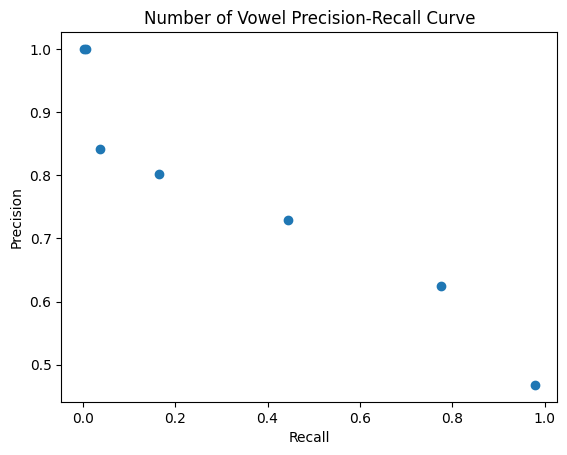

In [61]:
precision_list = []
recall_list= []
fscore_list = []
for i in range(1, 8):
  dev_words, dev_labels = dev_data
  y_pred = vowel_length_threshold(train_data, dev_words, i)
  dprecision = get_precision(dev_labels, y_pred)
  drecall = get_recall(dev_labels, y_pred)
  dfscore = get_fscore(dev_labels, y_pred)
  precision_list.append(dprecision)
  recall_list.append(drecall)
  fscore_list.append(dfscore)

print("fscore_list is {}".format(fscore_list))
import matplotlib.pyplot as plt
plt.scatter(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Number of Vowel Precision-Recall Curve")
plt.show()
# threshold is 2

fscore_list is [0.6677658697444353, 0.703659976387249, 0.48333333333333334, 0.1587982832618026, 0.03286384976525822, 0.0, 0.0, 0.0]


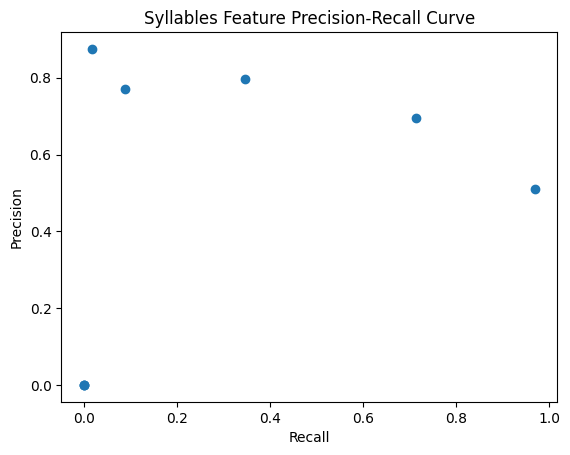

In [63]:
# Test syllables feature
# True means complex word
# False means: simple word
def syllables_threshold_feature(word, threshold):
  return syllables.estimate(word) > threshold

def syllables_threshold(train_data, dev_words, syllables_threshold=7):
    twords, tlabels = train_data
    dev_pred = []
    for word in dev_words:
      dev_pred.append(syllables_threshold_feature(word, syllables_threshold))
    return dev_pred


dev_words, dev_labels = dev_data
precision_list = []
recall_list= []
fscore_list = []
for i in range(1, 9):
  y_pred = syllables_threshold(train_data, dev_words, i)

  dprecision = get_precision(dev_labels, y_pred)
  drecall = get_recall(dev_labels, y_pred)
  dfscore = get_fscore(dev_labels, y_pred)
  precision_list.append(dprecision)
  recall_list.append(drecall)
  fscore_list.append(dfscore)

print("fscore_list is {}".format(fscore_list))
import matplotlib.pyplot as plt
plt.scatter(recall_list, precision_list)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Syllables Feature Precision-Recall Curve")
plt.show()
# threshold should be 2

In [64]:
tmp, train_labels = train_data
train_pred, model = get_my_own_feature_set(train_data, vowel_threshold=3, length_threshold=7, syllables_threshold=2)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)
print("train_precision is {}".format(train_precision))
print("train_recall is {}".format(train_recall))
print("train_fscore is {}".format(train_fscore))


train_precision is 0.6757965343767468
train_recall is 0.6984402079722704
train_fscore is 0.6869318181818181


In [65]:
dev_words, dev_labels = dev_data
lr_train_pred, lr_dev_pred = my_svm_model(train_data, dev_words, vowel_threshold=2, length_threshold=7, syllables_threshold=2)
dev_precision = get_precision(dev_labels, lr_dev_pred)
dev_recall = get_recall(dev_labels, lr_dev_pred)
dev_f = get_fscore(dev_labels, lr_dev_pred)

print("dev_precision is {}".format(dev_precision))
print("dev_recall is {}".format(dev_recall))
print("dev_fscore is {}".format(dev_f))

dev_precision is 0.7053140096618358
dev_recall is 0.6985645933014354
dev_fscore is 0.701923076923077


In [70]:
# True Positive labled as complex words prediction is complex words
for i in range(0, 100):
  if dev_labels[i] == lr_dev_pred[i] and lr_dev_pred[i] == 1:
    print(dev_words[i], lr_dev_pred[i], dev_labels[i])

renewable 1 1
conventional 1 1
surprisingly 1 1
plummeted 1 1
retailers 1 1
scholarships 1 1
evolving 1 1
unfounded 1 1
evaded 1 1
inaccurate 1 1
textile 1 1
cooperation 1 1
centerpiece 1 1
ideology 1 1
secure 1 1
self-imposed 1 1
directive 1 1
requirements 1 1
attempting 1 1
doctorate 1 1
lifelike 1 1
confessions 1 1
retained 1 1
marveled 1 1
spokesman 1 1
rehabilitate 1 1
painfully 1 1


In [71]:
# True Negative labled as simple words prediction is simple words
for i in range(0, 100):
  if dev_labels[i] == lr_dev_pred[i] and lr_dev_pred[i] == 0:
    print(dev_words[i], lr_dev_pred[i], dev_labels[i])

hammer 0 0
showings 0 0
exceed 0 0
combed 0 0
sled 0 0
sure 0 0
media 0 0
seed 0 0
seats 0 0
nobody 0 0
world 0 0
trial 0 0
spotify 0 0
showed 0 0
hockey 0 0
warnings 0 0
peace 0 0
bay 0 0
arguing 0 0
fled 0 0
math 0 0
water 0 0
fitted 0 0
praising 0 0
given 0 0
rule 0 0
fathers 0 0
injury 0 0
bread 0 0
spent 0 0
hands 0 0
mixed 0 0
journal 0 0
watch 0 0
moved 0 0
earliest 0 0
humans 0 0
grains 0 0
gift 0 0
15-nation 0 0
28-nation 0 0
pool 0 0
fatal 0 0
earlier 0 0
seat 0 0
choose 0 0
track 0 0
rains 0 0


In [74]:
# False Simple labled as complex words prediction is simple words
for i in range(0, 100):
  if dev_labels[i] != lr_dev_pred[i] and lr_dev_pred[i] == 0:
    print("word: {} label: {} prediction: {}".format(dev_words[i], dev_labels[i], lr_dev_pred[i]))
    print("number of vowels {} number of syllables {}".format(count_vowel_feature(dev_words[i], 2), syllables.estimate(dev_words[i])))

word: coup label: 1 prediction: 0
number of vowels False number of syllables 1
word: lilting label: 1 prediction: 0
number of vowels False number of syllables 2
word: toughest label: 1 prediction: 0
number of vowels True number of syllables 2
word: recruit label: 1 prediction: 0
number of vowels True number of syllables 2
word: kinky label: 1 prediction: 0
number of vowels False number of syllables 2
word: concept label: 1 prediction: 0
number of vowels False number of syllables 2
word: mollusks label: 1 prediction: 0
number of vowels False number of syllables 2
word: scuffle label: 1 prediction: 0
number of vowels False number of syllables 2
word: friction label: 1 prediction: 0
number of vowels True number of syllables 2
word: jolted label: 1 prediction: 0
number of vowels False number of syllables 2
word: steamy label: 1 prediction: 0
number of vowels False number of syllables 2
word: furious label: 1 prediction: 0
number of vowels True number of syllables 2
word: weakness label: 1 

In [75]:
# False Complex labled as complex words prediction is simple words
for i in range(0, 100):
  if dev_labels[i] != lr_dev_pred[i] and lr_dev_pred[i] == 1:
    print("word: {} label: {} prediction: {}".format(dev_words[i], dev_labels[i], lr_dev_pred[i]))
    print("number of vowels {} number of syllables {}".format(count_vowel_feature(dev_words[i], 2), syllables.estimate(dev_words[i])))

word: academy label: 0 prediction: 1
number of vowels True number of syllables 4
word: continues label: 0 prediction: 1
number of vowels True number of syllables 3
word: go-ahead label: 0 prediction: 1
number of vowels True number of syllables 3
word: overthrown label: 0 prediction: 1
number of vowels True number of syllables 3
word: personal label: 0 prediction: 1
number of vowels True number of syllables 3
word: firefighters label: 0 prediction: 1
number of vowels True number of syllables 4
word: opened label: 0 prediction: 1
number of vowels True number of syllables 3
word: police label: 0 prediction: 1
number of vowels True number of syllables 3
word: licenses label: 0 prediction: 1
number of vowels True number of syllables 3


In [68]:
syllables.estimate("coup")

1

In [ ]:
for i in range(0, 500):
  if dev_labels[i] != lr_dev_pred[i] and lr_dev_pred[i] == 1:
    print(dev_words[i], lr_dev_pred[i], dev_labels[i])

academy 1 0
continues 1 0
go-ahead 1 0
spotify 1 0
overthrown 1 0
personal 1 0
firefighters 1 0
licenses 1 0
best-selling 1 0
elementary 1 0
interim 1 0
attorney 1 0
businesses 1 0
failure 1 0
same-day 1 0
minister 1 0
threatened 1 0
condition 1 0
movement 1 0
cheeseburgers 1 0
delivers 1 0
manipulating 1 0
spontaneous 1 0
fireworks 1 0
proliferate 1 0
environmental 1 0
unarmed 1 0
directed 1 0
attached 1 0
infections 1 0
caffeine 1 0
federation 1 0
unlikely 1 0
several 1 0
unexpected 1 0
accepted 1 0
rainwater 1 0
pressure 1 0
unearthed 1 0
shattered 1 0
remained 1 0
spacecraft 1 0
continue 1 0
father-daughter 1 0
no-food-or-drink 1 0
politicians 1 0
libraries 1 0
outrage 1 0
practically 1 0
syndrome 1 0
helicopter 1 0
behaviors 1 0
government 1 0
believe 1 0
elevator 1 0
perpetrated 1 0
surprise 1 0


- **Answer 4.1**: Train your best model on the training data, and report the precision, recall, and f-score on the development data

In [ ]:
syllables.estimate("patterns")

2

In [ ]:
## Answer in your writeup.pdf
dev_words, dev_labels = dev_data
lr_train_pred, lr_dev_pred = my_logistic_regression(train_data, dev_words, vowel_threshold=2, length_threshold=7, syllables_threshold=3)
dev_precision = get_precision(dev_labels, lr_dev_pred)
dev_recall = get_recall(dev_labels, lr_dev_pred)
dev_f = get_fscore(dev_labels, lr_dev_pred)

print("dev_precision is {}".format(dev_precision))
print("dev_recall is {}".format(dev_recall))
print("dev_fscore is {}".format(dev_f))

dev_precision is 0.6561181434599156
dev_recall is 0.7440191387559809
dev_fscore is 0.6973094170403589


## 4.2 Analyze your model


Describe the model and features you choose, and perform a detailed error analysis of your models. Give several examples of words on which your best model performs well. Also give examples of words which your best model performs poorly on, and identify at least TWO categories of words on which your model is making errors.




- **Answer 4.2**: Write a detailed description of your model and features used. Also include error analysis of your model.

In [ ]:
## Answer in your writeup.pdf
"""
I used logistic regression model with 3 features.
I select 3 features:
1.  The number of vowels in the word: the best value to use is 2 which offers largest fscore for this feature only.
2.  The length of the word: the best value to use is 7, which offers largest fscore for this feature only
3.  The number of syllables of the word: the best value to use is 2, which offers largest fscore for this feature.
For each feature, I tested separately to find the optimized threshold, and then applied the threshold.
I also tested different value for these threshold, but
"""

'\nI used logistic regression model with 3 features.\nI select 3 features:\n1.  The number of vowels in the word: the best value to use is 2 which offers largest fscore for this feature only.\n2.  The length of the word: the best value to use is 7, which offers largest fscore for this feature only\n3.  The number of syllables of the word: the best value to use is 2, which offers largest fscore for this feature.\nFor each feature, I tested separately to find the optimized threshold, and then applied the threshold.\nI also tested different value for these threshold, but\n'

## 4.3 Leaderboard
Finally, use your classifier to predict labels for the test data, and submit these labels in a text file named `test_labels.txt` (with one label per line) to the leaderboard; be sure NOT to shuffle the order of the test examples. Instructions for how to post to the leaderboard will be posted on Ed soon.
**In addition, the top 3 submissions will receive 5 bonus points! A successful submission to the leaderboard will guarantee 2 points!**

In [ ]:
# train_pred, test_pred = `your_model_here`(train_data, test_words, ngram_counts)
tmp, train_labels = train_data
train_pred, model = get_my_own_feature_set(train_data, vowel_threshold=3, length_threshold=7, syllables_threshold=2)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)
print("train_precision is {}".format(train_precision))
print("train_recall is {}".format(train_recall))
print("train_fscore is {}".format(train_fscore))

with open('test_labels.txt', 'w') as f:
    f.write("\n".join(map(str, test_pred)))

In [ ]:
from sklearn.linear_model import LogisticRegression

def get_my_logistic_threshold_feature(train_data, ngram_counts):
    words, y_true = train_data
    features = []
    for word in words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    # TODO: calculate the scaled data, with the mean and std you just calculated
    X_scaled = (X - means) / stds

    classifier = LogisticRegression()
    classifier.fit(X_scaled, y_true)

    train_pred = classifier.predict(X_scaled)

    return train_pred, classifier

## Trains a logistic regression classifier using length and frequency features
def my_logistic_regression(train_data, dev_words, ngram_counts):
    ## TODO
    # train_pred, dev_pred = None, None
    train_pred, classifier = get_my_logistic_threshold_feature(train_data, ngram_counts)

    features = []
    for word in dev_words:
        ## YOUR CODE HERE
        # 1. word length feature
        # 2. unigram frequency feature
        # 3. (optional) syllables count feature
        length_feature = length_threshold_feature(word, 7)
        unigram_feature = frequency_threshold_feature(word, 15100, ngram_counts)
        # syllables_feature = syllables_threshold_feature(word, 7)
        # features.append([length_feature, unigram_feature, syllables_feature])
        features.append([length_feature, unigram_feature])

    X = np.asarray(features)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds

    dev_pred = classifier.predict(X_scaled)

    return train_pred, dev_pred

In [ ]:
tmp, train_labels = train_data
train_pred, my_logistic_model = get_my_logistic_threshold_feature(train_data, ngram_counts)
train_precision = get_precision(train_labels, train_pred)
train_recall = get_recall(train_labels, train_pred)
train_fscore = get_fscore(train_labels, train_pred)

print("train_precision is {}".format(train_precision))
print("train_recall is {}".format(train_recall))
print("train_fscore is {}".format(train_fscore))

train_precision is 0.6128888888888889
train_recall is 0.7966493356441363
train_fscore is 0.6927907560914344


In [ ]:
train_pred, test_pred = my_logistic_regression(train_data, test_words, ngram_counts)
with open('test_labels.txt', 'w') as f:
    f.write("\n".join(map(str, test_pred)))

- **Results 4.3**: Upload your `test_labels.txt` to the leaderboard in Gradescope.

## 4.4. (Optional) Leaderboard using outside data

While the training data we have provided is sufficient for completing this assignment, it is not the only data for the task of identifying complex words. As an optional addition to this homework, you may look for and use any additional training data, and submit your predicted labels in a text file named `test_labels.txt` to the leaderboard.

As a start, we recommend looking at the [SemEval 2016 dataset](http://alt.qcri.org/semeval2016/task11/), a dataset that was used in a complex words identification competition. In addition, you can try to use data from [Newsela](https://newsela.com/). Newsela’s editors re-write newspaper articles to be appropriate for students at different grade levels. The company has generously shared a dataset with us. The Newsela data **may not** be re-distributed outside of Penn. You can find the data on eniac at `/home1/c/ccb/data/newsela/newsela_article_corpus_with_scripts_2016-01-29.1.zip`.

Good luck, and have fun!

# Submission
Here are the deliverables you need to submit to GradeScope:
- Write-up:
    - Answers to all questions labeled as `Answer #.#` in a file named `writeup.pdf`
- Code:
    - This notebook and py file: rename to `homework2.ipynb` and `homework2.py`. You can download the notebook and py file by going to the top-left corner of this webpage, `File -> Download -> Download .ipynb/.py`
- Leaderboard Results:
  - Your model’s output for the test set using only the provided training and development data (`test_labels.txt`)
  - (Optional) your model’s output for the test set, using any data that you want. (`test_labels.txt`)